In [1]:
# imports
import os
os.sys.path.append(os.path.abspath("../.."))

import tensorflow as tf

import pandas as pd
import numpy as np
import h5py

from matplotlib import pyplot as plt

from project.notebooks_utils import visuals

from IPython.display import display

import project.download_content as content

from project.utils import data
from project.model.loss import BBOX_REF

from keras.preprocessing import image

from project.utils.data_bbox_match_hdf5 import load_ohc

from project.model.ssd_model_300_xception import ssd_model_300_xception
from project.model.loss import SSDloss

from project.utils.train_test.data_bbox_match_hdf5 import load_model
from project.utils.category_encoder import CategoryEncoder

from project.utils import data_augmentation as da

# one hot encoding
ohc = load_model()

modelpath = os.path.join(os.path.abspath(content.DATAPATH), 'MODEL')

train_files = [f'/media/external/clothing_300x300_{i}.h5'
               for i in range(8)]

val_files = [os.path.join(modelpath, f'39_classes_300x300_cross_val_{i}.h5')
             for i in range(8)]

test_files = [os.path.join(modelpath, f'39_classes_300x300_test_{i}.h5')
              for i in range(8)]



Using TensorFlow backend.


In [24]:
boxes = [[.5, .5, .7, .7], [.5, .5, .8, .8]]

result = tf.image.non_max_suppression(boxes,
                                      [0, 0.8],
                                      max_output_size=5,
                                      iou_threshold=.5)

tf.gather(boxes, result, axis=0)

<tf.Tensor: id=6787, shape=(2, 4), dtype=float32, numpy=
array([[0.5, 0.5, 0.8, 0.8],
       [0.5, 0.5, 0.7, 0.7]], dtype=float32)>

In [19]:
# loading OHC to validate classes
ohc = load_ohc()
ohc

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'bool'>, handle_unknown='error', n_values=None,
              sparse=False)

In [ ]:
f = h5py.File('/media/external/clothing_300x300_0.h5', 'r')

### Loading one image

In [157]:
# loading a random file of validation dataset
with h5py.File(train_files[5], 'r') as f:
    # selecting a random batch and getting their references
    x_ref, y_ref = f['batches'][3]
    
    # getting Images and Targets from the batch chosen
    X = f[x_ref][:]
    y = f[y_ref][:]
    
display(X.shape)
display(y.shape)

(12, 300, 300, 3)

(12, 8732, 6)

In [156]:
# loading a random file of validation dataset
with h5py.File(val_files[3], 'r') as f:
    # selecting a random batch and getting their references
    x_ref, y_ref, info, bboxes_ref = f['batches'][3]
    
    # getting Images and Targets from the batch chosen
    X = f[x_ref][:]
    y = f[y_ref][:]
    info = f[info][:]
    
display(X.shape)
display(y.shape)
display(info.shape)

bboxes_ref

(300, 300, 300, 3)

(300, 8732, 44)

(300, 2)

'f0bd2837-8b79-4de2-a986-ec0a4bf9708d-bboxes'

{0.0, 1.0}

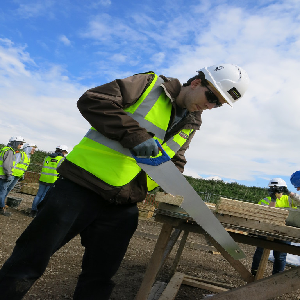

In [158]:
sample = 8

# getting a specific image from the batch
img = X[sample]

# getting it target
target = y[sample]

# metadata about the image
# id, raw_path = info[sample]

# with h5py.File(val_files[3], 'r') as f:
#     bboxes = f[bboxes_ref][id][:]

# validate that target has at least one bboxes matched
# (containing 1 and 0 in the first columns (no-class))
display(set(target[:, 0]))

image.array_to_img(img)
# bboxes

In [159]:
for i, x in enumerate(target[:, 1]):
    if x == 1:
        print(i, target[i])

8728 [0.     1.     0.4612 0.5815 0.6777 0.6733]


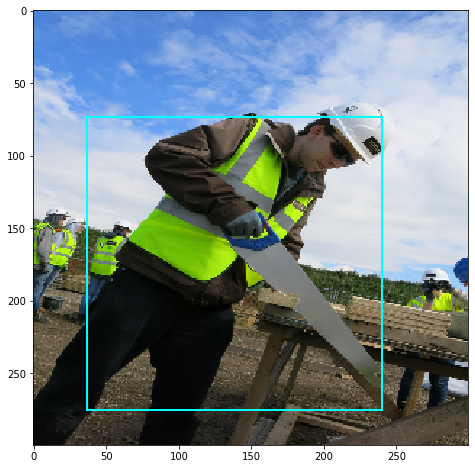

In [161]:
img_jpg = image.array_to_img(img)

plt.figure(figsize=(12,8))
plt.imshow(img_jpg)

visuals.draw_bbox(img_jpg, target[8728, -4:]);

## model

The model has 7 layers to draw the bounding_boxes, they were called as `number_bbs`

in each layer there are some types of bouding boxes, specified as follow:

|         | number of regions | size of filter in pixels | ratios w/h          | number of bounding boxes |
|---------|-------------------|--------------------------|---------------------|--------------------------|
| 1st_bbs | 5776              | 24px/24px                | [1, 1/2, 2]         | 17328                    |
| 2nd_bbs | 1369              | 48px/48px                | [1, 1/2, 2]         | 4107                     |
| 3rd_bbs | 289               | 98px/98px                | [1, 1/2, 1/3, 2, 3] | 1445                     |
| 4th_bbs | 49                | 208px/208px              | [1, 1/2, 1/3, 2, 3] | 245                      |
| 5th_bbs | 25                | 267px/267px              | [1, 1/2, 1/3, 2, 3] | 125                      |
| 6th_bbs | 9                 | 374px/374px              | [1, 1/2, 1/3, 2, 3] | 45                       |
| 7th_bbs | 1                 | 623px/624px              | [1, 1/2, 1/3, 2, 3] | 5                        |

In [150]:
model = ssd_model_300_xception()

display(model.summary())

model.load_weights(os.path.abspath(content.DATAPATH)
                   + '/simplesloss-clothing-weights300vgg16.h5')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

None

## Training

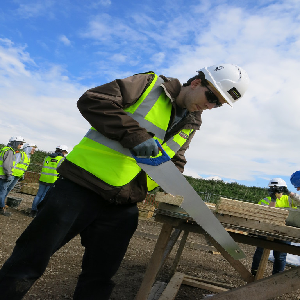

In [162]:
image.array_to_img(img)

In [171]:
norm_img = da.normalize(img)
pred = model.predict(np.expand_dims(norm_img, axis=0))[0]

best = []

for num in range(8732):
    target[num][-4:]
    pred[:, -4:][num]

    pred_trans = transf(pred[:, -4:][num],
                        BBOX_REF.references.iloc[num].values)

    i = iou.iou(target[num][-4:], np.array(pred_trans))

    if i > 0:
        print(num, i)
        best.append((num, pred_trans))
        
for num, _ in best:
    print("target: ", pred[num])

8728 [0.81655699]
target:  [ 0.72598857  0.27401137  0.00328364  0.10704712 -0.14130652 -0.23104894]


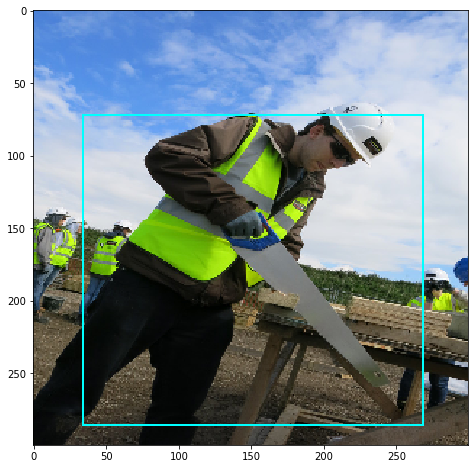

In [172]:
img_jpg = image.array_to_img(img)

plt.figure(figsize=(12,8))
plt.imshow(img_jpg)

visuals.draw_bbox(img_jpg, best[0][1])

In [57]:
from project.model import iou
display(iou.lower_right(np.expand_dims([0.7, 0.3, 0.2, 0.2],
                                       axis=0)))
display(iou.upper_left(np.expand_dims([0.7, 0.3, 0.2, 0.2],
                                       axis=0)))

(array([0.8]), array([0.4]))

(array([0.6]), array([0.2]))

In [120]:
def transf(p, d):
    # cx, cy, w, h
    r = [0, 0, 0, 0]
    r[0] = p[0]*d[2] + d[0]
    r[1] = p[1]*d[3] + d[1]
    
    r[2] = np.math.exp(p[2]) * d[2]
    r[3] = np.math.exp(p[3]) * d[3]
    
    return r

In [43]:
BBOX_REF.references.iloc[8696].values

array([0.16666667, 0.5       , 0.25333333, 0.25333333])

In [41]:
target = CategoryEncoder.transform(bboxes)
np.argmax(target[:, :-4], axis=1)

array([20,  0, 26, 10])

In [55]:
for i, r in enumerate(target[:, 0]):
    if r == 0:
        print(i)

8728
8729
8730
8731


1

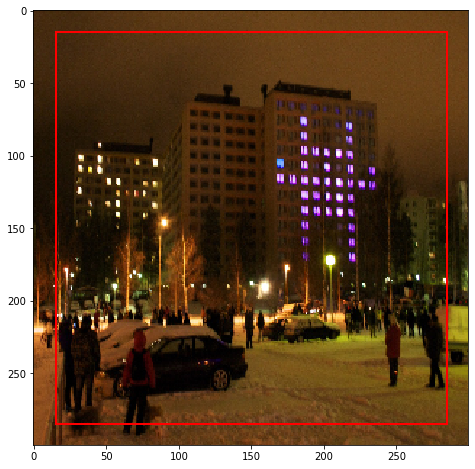

In [14]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        [cx, cy, w, h]
        
        visuals.draw_bbox(img, ref, color="#ff0000")
tt

1

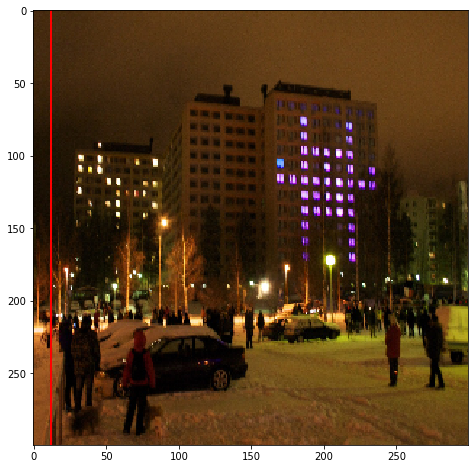

In [18]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        
        
        visuals.draw_bbox(img, [cx, cy, w, h], color="#ff0000")
tt

In [17]:
h

2.243039